<a href="https://colab.research.google.com/github/Krumpu/Homework_ICA/blob/main/HW_1_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - ANÁLISE DO DATASET E SUAS CARACTERÍSTICAS

Códigos para importação do conjunto de dados, para determinação do número de amostras, de preditores e quais serão as classes analisadas.

In [23]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

shutil.rmtree("./img")
os.makedirs('./img/unconditional_monovariate/', exist_ok=True)
os.makedirs('./img/conditional_monovariate/', exist_ok=True)

plt.style.use('_mpl-gallery')
plt.rcParams.update({'font.size': 20})
sns.set_theme(style="ticks")

url = 'https://raw.githubusercontent.com/Krumpu/Homework_ICA/main/Data-Melbourne_F.csv'
df = pd.read_csv(url)

# We can remove "year", "month" and "day" columns,
# since we did no time series analysis today...
# "VG" is removed, we do not have any info about
df = df.drop(['SLP', 'VG', 'year', 'month', 'day'], axis=1)

# Transformando a unidade do consumo energético de kWh para MGh
df['total_grid'] = df['total_grid'].div(1000)

# Information about our data set
print('Number of Observations (N): ', df.shape[0])
print('Number of Predictor Variables (D): ', df.shape[1])

# Q diabos é isso abaix kaique??? Why?
print(df['COD'].describe())
print(df['BOD'].describe())

Number of Observations (N):  1382
Number of Predictor Variables (D):  15
count    1382.000000
mean      845.960434
std       145.416540
min       360.000000
25%       751.250000
50%       845.000000
75%       920.000000
max      1700.000000
Name: COD, dtype: float64
count    1382.000000
mean      382.061708
std        85.996012
min       140.000000
25%       330.000000
50%       360.000000
75%       422.980000
max       850.000000
Name: BOD, dtype: float64


## 1.1 - **Classes**

Como indicadores de economia/deseperdicio durante o tratamento, utilizaremos as métricas COD e BOD, que respectivamente significam Chemical Oxygen Demand (mg/L) e Biological Oxygen Demand (mg/L).\
\
Dessa forma, podemos dividir o intervalo desses indicadores em n partes, utilizando-as como classificação.\
\
A Chemical Oxygen Demand(COD), indica a quantidade de oxigênio utilizado durante a reação quimica para consumir contaminantes presentes. \
Já a Biological Oxygen Demand(BOD), é a unidade de medida utilizada para determinar a quantidade de oxigênio utilizado por organismos biológicos aeróbicos. \
Com os dois indicativos construiremos classes formadas da combinação dos dois intervalos criados pela média de COD e de BOD. \
\
Iremos dividir os nossos dados em 3 intervalos para cada um dos seguintes preditores:\
COD:\
  Baixo: 360 - 790;\
  Medio: 791 - 890;\
  Alto: 891 - 1700.\
\
BOD:\
  Baixo: 140 - 340;\
  Medio: 341 - 400;\
  Alto: 401 - 850.\
\
PP:\
  Sem chuva: <0.1;\
  Leve: 0.1 - 1;\
  Moderada: >1;\
\

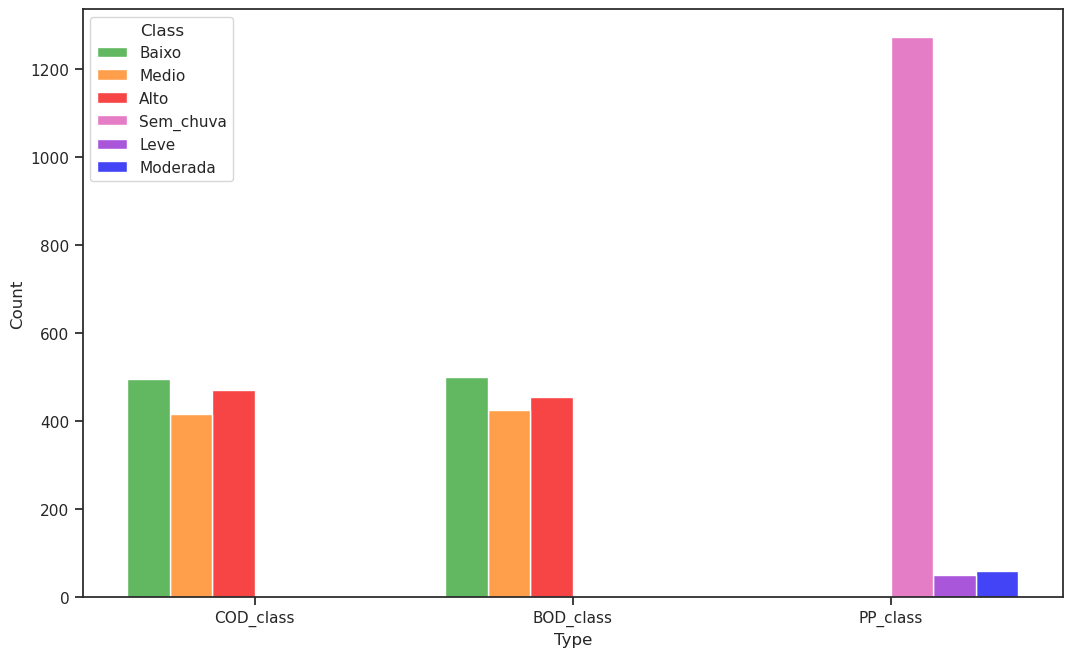

In [25]:
df.loc[(df['COD'] >= 360) & (df['COD'] <= 790), "COD_class"] = "Baixo"
df.loc[(df['COD'] >= 791) & (df['COD'] <= 890), "COD_class"] = "Medio"
df.loc[(df['COD'] >= 891) & (df['COD'] <= 1700), "COD_class"] = "Alto"

df.loc[(df['BOD'] >= 140) & (df['BOD'] <= 340), "BOD_class"] = "Baixo"
df.loc[(df['BOD'] >= 341) & (df['BOD'] <= 400), "BOD_class"] = "Medio"
df.loc[(df['BOD'] >= 401) & (df['BOD'] <= 850), "BOD_class"] = "Alto"

df.loc[df['PP'] < 0.1, "PP_class"] = "Sem_chuva"
df.loc[(df['PP'] >= 0.1) & (df['PP'] <= 1), "PP_class"] = "Leve"
df.loc[df['PP'] > 1, "PP_class"] = "Moderada"

df_classes = df[['COD_class', 'BOD_class', 'PP_class']].copy()

paleta_todas = {
    "Baixo": "#2ca02c",
    "Medio": "#ff7f0e",
    "Alto":  "#F50505",
    "Sem_chuva": "#DD50B3",
    "Leve": "#8E1ECF",
    "Moderada": "#0505F5",
    "nan": "#000000"
}

paleta_Xod = {
    "Baixo": "#2ca02c",
    "Medio": "#ff7f0e",
    "Alto":  "#F50505",
    "nan": "#000000"
}

paleta_pp = {
    "Sem_chuva": "#DD50B3",
    "Leve": "#8E1ECF",
    "Moderada": "#0505F5",
    "nan": "#000000"
}

# Class distribution
plt.figure(figsize=(10,6))
sns.histplot(
    data=df_classes.melt(var_name='Type', value_name='Class'),
    x='Type',
    hue='Class',
    hue_order=['Baixo', 'Medio', 'Alto', 'Sem_chuva', 'Leve', 'Moderada'],
    multiple='dodge',   # or 'stack'
    shrink=0.8,
    palette=paleta_todas
)
plt.show()



---
# 2 - ANÁLISE INCONDICIONAL MONOVARIADA

Análise de cada preditor individualmente. É a forma mais simples de analisar os dados

In [3]:
def analyze_dataset(df: pd.DataFrame):
    stats_analysis = pd.DataFrame(columns=['name', 'mean', 'std_deviation', 'skewness'])

    for index, predictor in enumerate(df.select_dtypes('number').columns):
        stats_analysis.loc[index] = [
            predictor,
            np.round(df[predictor].mean(), 2),
            np.round(df[predictor].std(), 2),
            np.round(df[predictor].skew(), 2),
        ]

    # For index starting at 1
    stats_analysis.index = stats_analysis.index + 1
    return stats_analysis


generated_files = []
for i, predictor in enumerate(df.select_dtypes('number').columns):
    fig, axs = plt.subplots(1, 2, figsize=(18,9))

    _, bins, _ = axs[0].hist(df[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::4], title=f'{predictor} histogram')
    axs[1].boxplot(df[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 1.0},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                          "linewidth": 1.0},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

    plt.tight_layout()

    filename = f'./img/unconditional_monovariate/plot_{predictor}.png'
    fig.savefig(filename, bbox_inches='tight')
    generated_files.append(filename)
    plt.close(fig)
analyze_dataset(df)

,name,mean,std_deviation,skewness
1,avg_outflow,3.93,1.23,0.38
2,avg_inflow,4.51,1.44,3.75
3,total_grid,275.16,44.64,-0.15
4,Am,39.22,7.76,0.31
5,BOD,382.06,86.00,1.23
6,COD,845.96,145.42,0.74
7,TN,62.74,3.57,-0.26
8,T,15.04,5.40,0.55
9,TM,20.53,7.10,0.49
10,Tm,10.04,4.66,0.50


In [4]:
# Compactação dos arquivos para fazer o download
# !zip -r plots.zip ./img

---
# 3 - ANÁLISE **CONDICIONAL** MONOVARIADA
Descrever e investigar como os preditores distribuem-se entre as classes

## 3.1 - CHEMICAL OXYGEN DEMAND (COD)

### 3.1.1 - BAIXO

In [5]:
def class_plot(predict_col: str, class_name: str):
  sub_df = df.loc[df_classes[predict_col] == class_name].copy()
  numeric_predictors = sub_df.select_dtypes(include=['number']).columns

  for predictor in numeric_predictors:
    fig, axs = plt.subplots(1, 2, figsize=(18,9))

    _, bins, _ = axs[0].hist(sub_df[predictor], bins=16, linewidth=0.5, edgecolor='white')
    axs[0].set(xticks=bins[::4], title=f'{predictor} histogram')
    axs[1].boxplot(sub_df[predictor], patch_artist=True,
                medianprops={"color": "white", "linewidth": 0.5},
                boxprops={"facecolor": "C0", "edgecolor": "white",
                        "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
    axs[1].set(title=f'{predictor} boxplot')

    plt.tight_layout()

    filename = f'./img/conditional_monovariate/plot_{predictor}.png'
    fig.savefig(filename, bbox_inches='tight')
    generated_files.append(filename)
    plt.close(fig)

  print(analyze_dataset(sub_df))

# Analise Condicional do tipo  COD_Baixo
class_plot('COD_class', 'Baixo')

           name    mean  std_deviation  skewness
1   avg_outflow    3.96           1.21      0.86
2    avg_inflow    4.48           1.46      3.07
3    total_grid  275.68          47.25     -0.20
4            Am   36.34           7.96      0.32
5           BOD  337.74          57.49      0.79
6           COD  704.99          73.41     -1.44
7            TN   60.21           3.24     -2.19
8             T   14.11           5.08      0.88
9            TM   19.14           6.67      0.71
10           Tm    9.49           4.44      0.69
11            H   66.24          14.22     -0.81
12           PP    0.30           1.44      7.69
13           VV   10.76          25.50     15.92
14            V   19.68           7.06      0.95
15           VM   35.20          11.33      0.81


### 3.1.2 MÉDIO

In [6]:
# Analise Condicional do tipo  COD_Médio
class_plot('COD_class', 'Medio')

           name    mean  std_deviation  skewness
1   avg_outflow    3.94           1.21      0.33
2    avg_inflow    4.54           1.63      4.47
3    total_grid  270.74          43.94     -0.14
4            Am   40.35           7.58      1.03
5           BOD  385.20          67.19      0.73
6           COD  844.84          26.11      0.03
7            TN   63.15           2.19     -0.57
8             T   15.97           5.52      0.46
9            TM   21.86           7.28      0.47
10           Tm   10.60           4.81      0.41
11            H   63.43          14.36     -0.64
12           PP    0.28           1.56      7.59
13           VV    8.34           7.30      6.09
14            V   19.30           7.19      0.83
15           VM   35.47          11.69      0.60


### 3.1.3 - ALTO

In [7]:
# Analise Condicional do tipo COD_Alto
class_plot('COD_class', 'Alto')

           name    mean  std_deviation  skewness
1   avg_outflow    3.90           1.27     -0.01
2    avg_inflow    4.50           1.22      3.13
3    total_grid  278.51          42.14     -0.07
4            Am   41.25           6.76      0.00
5           BOD  425.87         101.33      1.00
6           COD  995.11         112.45      2.59
7            TN   65.05           3.16      2.00
8             T   15.19           5.47      0.33
9            TM   20.81           7.12      0.27
10           Tm   10.12           4.69      0.38
11            H   60.86          14.53     -1.02
12           PP    0.08           0.81     13.82
13           VV    8.03           6.93      5.20
14            V   19.43           7.18      0.73
15           VM   35.49          11.89      0.28


## 3.2 - BIOLOGICAL OXYGEN DEMAND (BOD)

### 3.2.1 - BAIXO

In [8]:
# Analise Condicional do tipo BOD_Baixo
class_plot('BOD_class', 'Baixo')

           name    mean  std_deviation  skewness
1   avg_outflow    4.15           1.33      0.18
2    avg_inflow    4.79           1.68      3.86
3    total_grid  280.76          45.16     -0.27
4            Am   38.59           8.97      0.68
5           BOD  307.61          33.60     -1.65
6           COD  784.28         137.69      0.05
7            TN   61.21           3.78     -1.37
8             T   13.88           5.26      0.57
9            TM   19.04           6.88      0.67
10           Tm    9.41           4.60      0.45
11            H   65.68          14.48     -1.22
12           PP    0.17           1.18     10.29
13           VV    8.67           9.07      5.42
14            V   19.63           7.34      0.79
15           VM   35.21          11.74      0.56


### 3.1.5 - MÉDIO

In [9]:
# Analise Condicional do tipo BOD_Medio
class_plot('BOD_class', 'Medio')

           name    mean  std_deviation  skewness
1   avg_outflow    3.94           1.22      0.50
2    avg_inflow    4.49           1.39      3.27
3    total_grid  278.32          44.52     -0.22
4            Am   38.52           6.97      0.00
5           BOD  366.79          14.92      0.56
6           COD  834.33         120.38      0.79
7            TN   62.66           2.68      0.39
8             T   15.37           5.43      0.65
9            TM   20.92           7.29      0.47
10           Tm   10.08           4.63      0.57
11            H   62.50          14.71     -0.65
12           PP    0.25           1.33      8.65
13           VV   10.36          26.57     16.25
14            V   19.48           6.86      0.76
15           VM   35.77          11.68      0.47


### 3.2.3 - ALTO

In [10]:
# Analise Condicional do tipo BOD_Alto
class_plot('BOD_class', 'Alto')

           name    mean  std_deviation  skewness
1   avg_outflow    3.68           1.07      0.31
2    avg_inflow    4.21           1.09      3.18
3    total_grid  266.17          42.81      0.00
4            Am   40.58           6.82     -0.09
5           BOD  478.13          73.98      1.81
6           COD  924.73         139.22      1.88
7            TN   64.50           3.26      1.61
8             T   16.00           5.30      0.50
9            TM   21.79           6.87      0.36
10           Tm   10.68           4.66      0.52
11            H   62.21          14.20     -0.56
12           PP    0.25           1.41      7.73
13           VV    8.40           7.54      5.51
14            V   19.31           7.18      0.94
15           VM   35.23          11.48      0.62


## 3.3 - Chuva/Neve

### 3.3.1 - SEM CHUVA

In [11]:
# Analise Condicional do tipo Sem_chuva
class_plot('PP_class', 'Sem_chuva')

           name    mean  std_deviation  skewness
1   avg_outflow    3.97           1.25      0.29
2    avg_inflow    4.57           1.47      3.70
3    total_grid  275.75          44.95     -0.16
4            Am   39.41           7.81      0.31
5           BOD  382.64          86.89      1.24
6           COD  851.90         145.44      0.73
7            TN   62.78           3.63     -0.29
8             T   15.10           5.48      0.54
9            TM   20.61           7.18      0.48
10           Tm   10.07           4.72      0.50
11            H   63.05          14.56     -0.85
12           PP    0.00           0.00      0.00
13           VV    8.42           8.54      6.05
14            V   19.47           7.21      0.84
15           VM   35.32          11.70      0.56


### 3.3.2 - CHUVA LEVE

In [12]:
# Analise Condicional do tipo (chuva) Leve
class_plot('PP_class', 'Leve')

           name    mean  std_deviation  skewness
1   avg_outflow    3.52           0.87      2.22
2    avg_inflow    3.87           0.70      1.97
3    total_grid  275.22          40.97     -0.43
4            Am   37.37           6.92     -0.31
5           BOD  362.22          74.55      1.22
6           COD  746.47         116.55      0.43
7            TN   61.90           3.17      0.58
8             T   13.89           3.77      0.39
9            TM   18.54           5.46     -0.35
10           Tm    9.21           3.61      0.28
11            H   68.51          11.19     -0.17
12           PP    0.39           0.16      0.60
13           VV   11.43          13.59      5.04
14            V   18.88           6.16      0.71
15           VM   33.16          10.01      0.74


### 3.3.3 - CHUVA MODERADA

In [13]:
# Analise Condicional do tipo (chuva) Moderada
class_plot('PP_class', 'Moderada')

           name    mean  std_deviation  skewness
1   avg_outflow    3.40           0.64      1.67
2    avg_inflow    3.78           0.60      2.53
3    total_grid  262.65          39.32      0.06
4            Am   36.65           6.84      0.42
5           BOD  385.89          73.88      0.97
6           COD  801.20         129.73      1.33
7            TN   62.61           2.37      0.13
8             T   14.73           4.66      0.44
9            TM   20.55           6.27      0.81
10           Tm   10.07           3.90      0.29
11            H   70.28          14.08     -0.10
12           PP    4.70           4.30      1.53
13           VV   21.74          65.87      7.24
14            V   20.18           6.34      0.88
15           VM   38.56          10.71      0.38


# 4 - ANÁLISE INCONDICIONAL **BIVARIADA**

### Descrever e investigar como os preditores distribuem-se entre si


           name    mean  std_deviation  skewness
1   avg_outflow    3.93           1.23      0.38
2    avg_inflow    4.51           1.44      3.75
3    total_grid  275.16          44.64     -0.15
4            Am   39.22           7.76      0.31
5           BOD  382.06          86.00      1.23
6           COD  845.96         145.42      0.74
7            TN   62.74           3.57     -0.26
8             T   15.04           5.40      0.55
9            TM   20.53           7.10      0.49
10           Tm   10.04           4.66      0.50
11            H   63.56          14.53     -0.81
12           PP    0.22           1.31      8.76
13           VV    9.10          16.32     22.20
14            V   19.48           7.14      0.83
15           VM   35.38          11.63      0.55


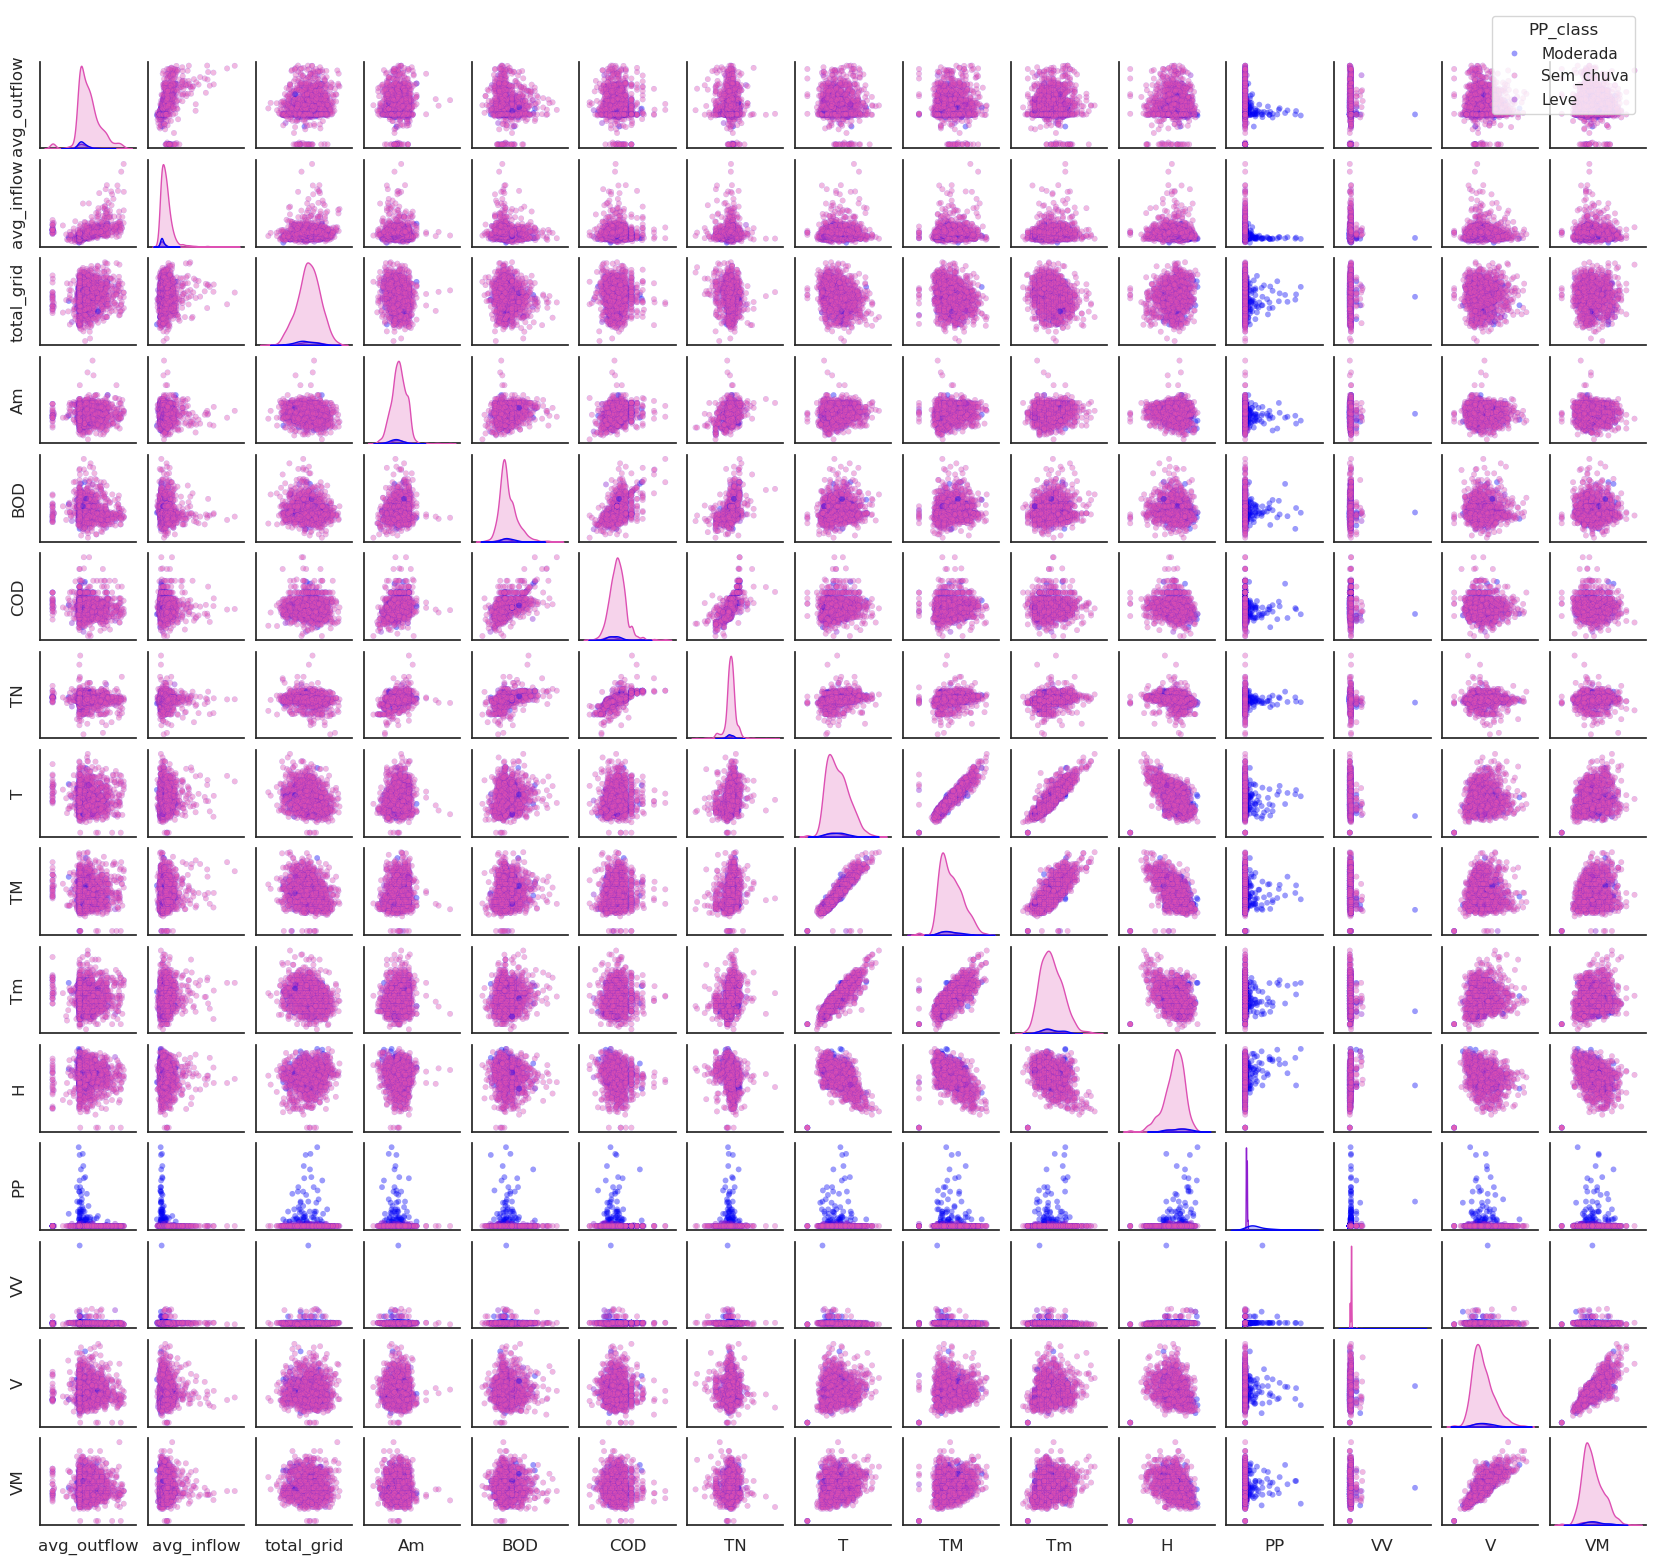

In [27]:
# Bivariate matrix plot wrap function

def bivariate_matrix(cl="", palette=None):

    print(analyze_dataset(df))

    pairgrid = sns.pairplot(
        df,
        height=1,
        aspect=1,
        plot_kws=dict(
            s=64,               # marker size
            alpha=0.4,          # transparency
            marker='.',         # marker type ('o', '^', '.', 'x', etc.)
            edgecolor="blue",   # thin black edge (set to 'none' to disable)
            linewidth=0.1,
        ),
        hue=cl,
        palette=palette
    )

    for ax in pairgrid.axes.flatten():
        if ax is not None:
            ax.grid(False)
            ax.set_facecolor("white")
            ax.set_xticks([])
            ax.set_yticks([])

    pairgrid.fig.tight_layout(pad=0.2)
    pairgrid.legend.set_bbox_to_anchor((1,1))
    pairgrid.legend.set_frame_on(True)
    plt.show()

# Unconditional bi-variate analysis of the predictors
# Highlight on the PP classes (still inconditional!)
bivariate_matrix('PP_class', paleta_pp)

# 5 - PCA

## Passos
1 - Normalização dos dados\
2 - Construção da matriz de covariancia\
3 - Determinação dos autovalores e autovetores da matriz de covariancia\
4 - Ordenação dos autovetores por autovalor
5 - Seleção

In [15]:
df_norm = df.select_dtypes('number')
df_norm = (df_norm - df_norm.mean())/df_norm.std()
df_norm.head()

,avg_outflow,avg_inflow,total_grid,Am,BOD,COD,TN,T,TM,Tm,H,PP,VV,V,VM
0,-0.805359,-1.331870,-2.224505,-1.574715,-0.198401,-0.797436,-0.661643,0.789723,0.643829,0.550295,-0.520057,0.996165,0.05504,1.039293,1.558419
1,-0.809428,-1.073462,-2.095295,-1.832394,-0.140259,-0.728668,-0.760214,0.382202,0.432465,0.485875,-0.038434,-0.166873,0.05504,-0.712176,-0.652075
2,-0.815939,-0.890076,-1.638490,0.357877,0.417906,-0.068496,0.498805,0.326631,0.939739,-0.265700,-1.139286,0.024416,0.05504,1.739880,2.212106
3,-0.815939,-0.800466,-1.514590,-0.415160,0.557448,0.027779,0.072597,-0.080890,-0.088899,0.228192,-1.001679,-0.166873,0.05504,1.053304,0.302652
4,-0.824891,-0.494822,-1.620390,0.873235,1.464467,1.169328,0.797877,-0.303175,-0.201627,-0.437489,0.099172,-0.166873,0.05504,0.156552,-0.015590


In [16]:
cov = df_norm.cov();
cov

,avg_outflow,avg_inflow,total_grid,Am,BOD,COD,TN,T,TM,Tm,H,PP,VV,V,VM
avg_outflow,1.000000,0.541923,0.167099,0.040590,-0.115811,-0.022723,-0.061951,-0.000163,0.006070,0.035516,-0.016560,-0.090001,-0.027635,-0.015406,-0.006319
avg_inflow,0.541923,1.000000,0.136211,-0.032709,-0.121364,0.018026,-0.035827,0.098149,0.093073,0.140905,-0.040534,-0.100358,-0.031872,-0.025010,-0.012203
total_grid,0.167099,0.136211,1.000000,-0.133076,-0.136945,0.000346,-0.167448,-0.266053,-0.245119,-0.222896,0.155245,-0.014242,0.007085,0.020656,0.017388
Am,0.040590,-0.032709,-0.133076,1.000000,0.164753,0.284552,0.342995,0.110000,0.099279,0.094802,-0.076970,-0.074313,-0.028647,-0.047966,-0.048622
BOD,-0.115811,-0.121364,-0.136945,0.164753,1.000000,0.524189,0.455843,0.150706,0.137368,0.133025,-0.087240,0.001186,-0.019039,0.001384,0.000370
COD,-0.022723,0.018026,0.000346,0.284552,0.524189,1.000000,0.681225,0.083946,0.090018,0.052716,-0.152655,-0.055335,-0.050351,-0.029496,-0.006580
TN,-0.061951,-0.035827,-0.167448,0.342995,0.455843,0.681225,1.000000,0.269751,0.259386,0.232274,-0.210108,-0.012618,-0.053080,-0.029228,0.006540
T,-0.000163,0.098149,-0.266053,0.110000,0.150706,0.083946,0.269751,1.000000,0.924944,0.890901,-0.553688,-0.004256,-0.122247,0.098620,0.219791
TM,0.006070,0.093073,-0.245119,0.099279,0.137368,0.090018,0.259386,0.924944,1.000000,0.759461,-0.533249,-0.003110,-0.120905,0.035349,0.199370
Tm,0.035516,0.140905,-0.222896,0.094802,0.133025,0.052716,0.232274,0.890901,0.759461,1.000000,-0.386078,0.030974,-0.090034,0.123755,0.181562


In [43]:
autovalores, autovetores= np.linalg.eig(cov)

print(autovalores)
print(autovetores)

[3.60626052 2.1795335  1.7412522  1.57827871 1.11426204 0.93379309
 0.8386384  0.76593459 0.6145323  0.52076852 0.42551977 0.03520242
 0.1341205  0.26903492 0.24286851]
[[ 8.00357249e-03  1.49992964e-01  4.23493490e-01  4.55120213e-01
   1.68717735e-01 -1.31559480e-01 -1.35343372e-01 -1.75521641e-01
   4.17277327e-02  3.81655965e-01 -5.87563616e-01  1.10762886e-02
   1.24400061e-02 -5.30182106e-02 -1.83252063e-02]
 [-3.89534904e-02  1.65308003e-01  4.58757512e-01  4.08478908e-01
   1.88595630e-01 -2.17024708e-02 -8.20241744e-03 -2.55439586e-01
   8.90406131e-03 -2.95431987e-01  6.22932469e-01  9.49490143e-03
   6.35857904e-03  1.08883821e-01  7.13860811e-02]
 [ 1.79931322e-01  9.28578565e-02  5.17605836e-02  3.42541100e-01
   9.81606067e-02  4.86668505e-01  1.61743939e-01  7.23166694e-01
  -1.39033120e-01  8.43772173e-02  2.87172735e-02  9.27607415e-03
   1.89454762e-02  1.24874323e-01  7.91759589e-03]
 [-1.35928594e-01 -2.89852863e-01  3.18911576e-02  1.31405493e-01
  -7.65495072e-02 

In [41]:
#Toericamente não precisa fazer isso aqui, posso só pegar os 2 maiores autovalore, mas eu fiz por curiosidade

variancia_total = np.sum(autovalores)
variancia_exp = autovalores/variancia_total

print(variancia_exp)

vet_maiores = (autovetores[0], autovetores[1])

[0.24041737 0.14530223 0.11608348 0.10521858 0.07428414 0.06225287
 0.05590923 0.05106231 0.04096882 0.0347179  0.02836798 0.00234683
 0.00894137 0.01793566 0.01619123]


[3.60626052 2.1795335  1.7412522  1.57827871 1.11426204 0.93379309
 0.8386384  0.76593459 0.6145323  0.52076852 0.42551977 0.26903492
 0.24286851 0.1341205  0.03520242]


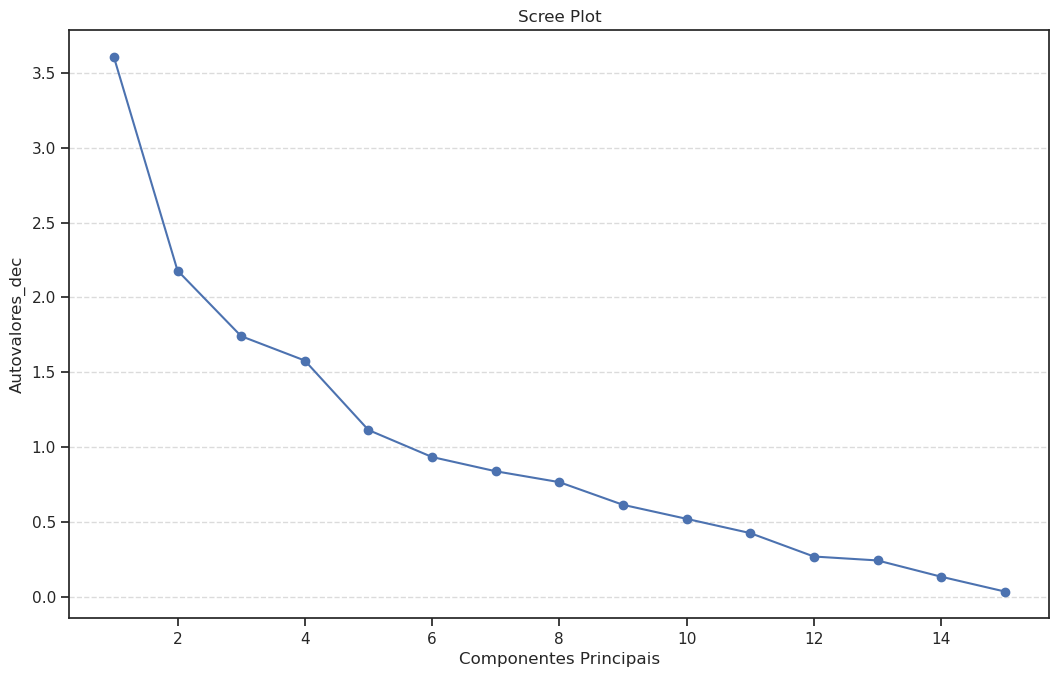

In [40]:
#screeplots
autovalores_dec = np.sort(autovalores)[::-1]
print(autovalores_dec)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autovalores_dec) + 1), autovalores_dec, marker='o', label='Autovalores_dec')
plt.xlabel('Componentes Principais')
plt.ylabel('Autovalores_dec')
plt.title('Scree Plot')
plt.grid(axis='y', linestyle='--', alpha=0.7)


O documento solicita somente os dois principais componentes

             0         1
0    -1.372079 -2.315536
1    -1.506180 -2.246643
2    -0.240987 -1.002955
3    -0.252815 -1.397483
4    -0.573980  0.089308
...        ...       ...
1377 -0.086825 -0.131676
1378 -0.324051  0.976123
1379  0.039669  1.160885
1380  0.268536  1.205905
1381 -0.300404  0.110960

[1382 rows x 2 columns]


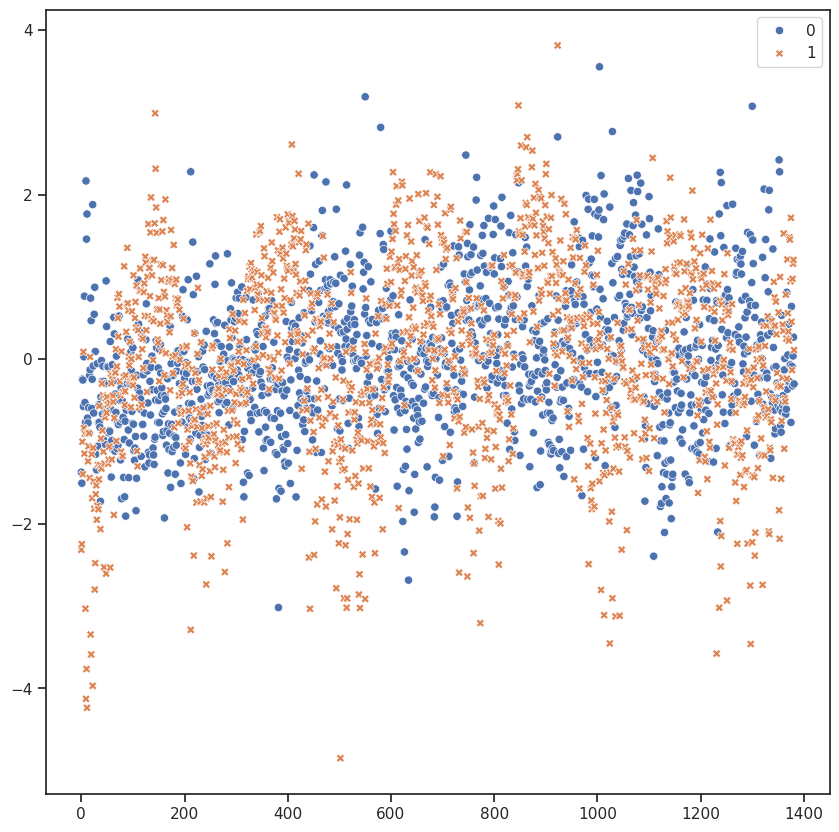

In [44]:
pca_df = np.matmul(vet_maiores,np.transpose(df_norm))
pca_df = np.transpose(pca_df)
print(pca_df)
pca_df[['COD_class', 'BOD_class', 'PP_class']] = df_classes[['COD_class', 'BOD_class', 'PP_class']]

g = sns.scatterplot(
    pca_df,
)
g.figure.set_figwidth(8)
g.figure.set_figheight(8)
